# Time series analysis tutorial

데이터 링크는 [Superstore sales data](https://community.tableau.com/docs/DOC-1236)입니다.

튜토리얼의 목적은 **<font color=red>시계열 데이터를 분석하여 furniture(가구)의 판매를 예측</font>**하는 것입니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import itertools
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm

## 데이터 로딩

`pip install xlrd`

In [4]:
pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [5]:
df = pd.read_excel("./input/Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
df.shape

(9994, 21)

*Category*컬럼에서 값이 *Furniture*인 데이터를 불러옵니다.

In [7]:
furniture = df.loc[df.Category == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


데이터의 시점과 종점을 살펴봅니다.

In [8]:
print('시점 :', furniture['Order Date'].min())
print('종점 :', furniture['Order Date'].max())

시점 : 2014-01-06 00:00:00
종점 : 2017-12-30 00:00:00


총 4년 동안의 데이터 입니다.

해당 컬럼의 데이터 타입을 살펴봅니다

In [9]:
type(furniture['Order Date'].min())

pandas._libs.tslib.Timestamp

## Data Preprocessing
- 사용하지 않을 컬럼을 제거하겠습니다.
- Missing value를 체크합니다.
- 컬럼을 aggregation합니다.
- 시계열 인덱싱으로 변환합니다.

### 1. 사용하지 않을 컬럼 제거
- 사용하는 컬럼은 시간 정보가 있는 *Order Date*와, 그 날의 판매량인 *Sales* 입니다.

In [10]:
columns = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 
           'Customer ID', 'Customer Name', 'Segment', 'Country', 
           'City', 'State', 'Postal Code', 'Region', 
           'Product ID', 'Category', 'Sub-Category', 'Product Name', 
           'Quantity', 'Discount', 'Profit']

In [11]:
furniture.drop(columns, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [12]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


### 2. Missing value를 체크

In [13]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

### 3. 컬럼 aggregation

각 날짜별로 record의 수를 체크해봅니다.

In [14]:
furniture.groupby('Order Date').count().sort_values(by='Sales', ascending=False).head()

,Sales
Order Date,
2016-09-05,10
2016-12-25,9
2016-12-01,9
2017-11-19,9
2017-10-30,9


날짜별로 record의 수가 여러개 존재하는 경우가 있으므로, sales을 aggregation 합니다.

In [15]:
furniture = furniture.groupby('Order Date').agg({'Sales': 'sum'}).reset_index()
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


### 4. Indexing

In [16]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

시계열 데이터는 다루기 힘든 경우가 많습니다. 미시적(micro)인 관점에서 살펴보아도 좋지만, 먼저 거시적(macro)인 단위에서의 경향성을 예측해보고, 범위를 좁혀가는 방법이 좋습니다.

따라서, 1일 판매량 단위로 끊어서보지 않고, 1달 판매량의 평균으로 살펴보도록 하겠습니다.

Pandas는 시계열 데이터를 다룰때, range를 다루기 쉬운 메소드를 제공해줍니다.

`resample` reference : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [17]:
x = furniture['Sales'].resample('MS')
x.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

## Visualization

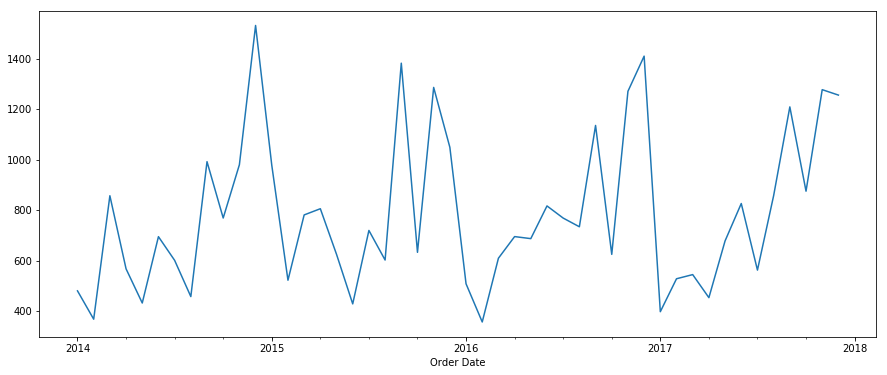

In [18]:
x.plot(figsize=(15, 6))

Time series decomposition
 - trend
 - seasonality
 - noise

In [19]:
# decomposition = sm.tsa.seasonal_decompose(x, 
#                                           model='additive', 
#                                           freq=30)
# fig = decomposition.plot()

## Time series forecasting with ARIMA

시계열 분석에 많이 사용하는 ARIMA를 사용하자.

(Autoregressive Integrated Moving Average)

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [21]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [22]:
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(p, d, q))]

In [23]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [24]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- Parameter selection for our furniture’s sales ARIMA time series model
- Grid search

In [25]:
import traceback

In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(x,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'
                  .format(param, param_seasonal, results.aic))
        except Exception:
#             print(results.mle_retvals)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1446.5593245884702


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1172.2086741447833
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.357535652858
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809126


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.580913309711
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1394870316744
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.988487694687
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1250.256448915547
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1550.2028404680511
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817347
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2683.886393076119
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482781
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774427826
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2500.937649122243
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417445
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1338.6458117766479
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.92593679351967


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1263.7349229114132
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084587
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218685
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:82073.66352065578
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815054
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876739
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002366451
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1276.5289307321336
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.34036587848493


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1097.4755401855066
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345443
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835516
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:101786.44160210912
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687609776
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546607727
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2651.570039388935
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439546606


최적의 parameter는 $(1,1,1)\times(1,1,0,12)$ 이다.

In [27]:
mod = sm.tsa.statespace.SARIMAX(x,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


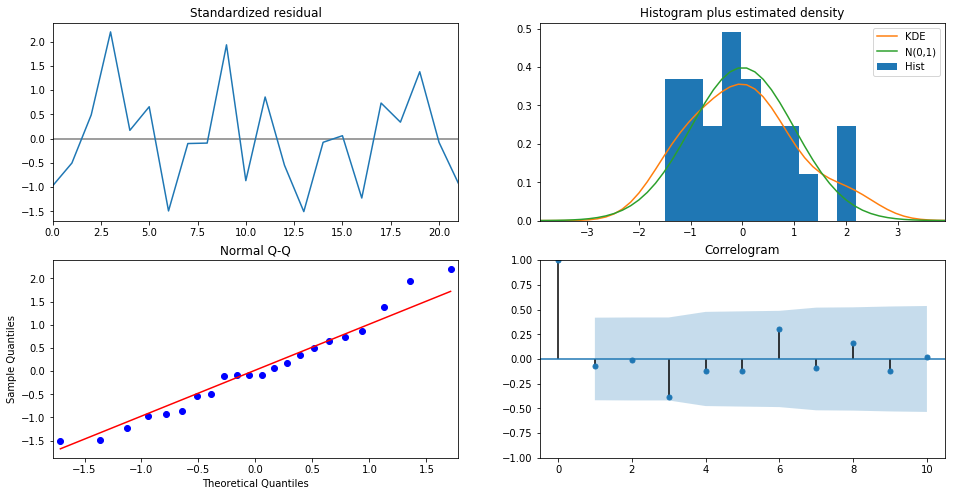

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Our model diagnostics suggests that the model residuals are near normally distributed.

### Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

In [29]:
x.tail()

Order Date
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

In [30]:
pd.to_datetime('2017-01-01')

Timestamp('2017-01-01 00:00:00')

In [31]:
pred = results.get_prediction(
    start=pd.to_datetime('2017-01-01'), dynamic=False)

pred_ci = pred.conf_int()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Timestamp'